# Task 1
This the first task of the Tensor Tournament 2024 invovling the prediction of how long a drone battery will last.

In [1]:
import pandas as pd

df_train = pd.read_csv('./data/task1/train.csv')
df_train.head()

,Unnamed: 0,battery_voltage,gps_signal_strength,air_traffic_density,wind_speed,warranty_number,temperature,obstacle_density,current_flight_time,time_remaining,...,country,drone_color,manufacturing_date,flight_mode,payload_weight,altitude,speed,manufacturer_name,battery_age,battery_health
0,0,14.309714,85.152973,0.786525,5.157676,911,23.320005,0.117675,15.993428,881.472185,...,China,Green,2020-04-12,1,1.519641,36.430105,11.044859,DJI,8.402622,0.911753
1,1,14.772507,74.223226,0.309916,6.125795,910,18.519420,0.266185,14.723471,913.703578,...,Japan,Red,2020-12-14,2,1.487178,43.890011,10.849971,DJI,5.852522,0.829599
2,2,15.006486,82.877186,0.807819,5.682204,806,19.667068,0.302744,16.295377,817.200807,...,USA,Blue,2020-09-27,0,1.690358,38.052379,7.190440,Skydio,4.660462,0.838449
3,3,15.374834,76.903808,0.673258,2.444172,819,19.123088,0.379534,18.046060,945.372919,...,China,Black,2020-04-16,1,1.806566,52.208361,11.738753,Skydio,6.504045,0.679419
4,4,15.812081,78.362986,0.319635,4.627559,551,22.570268,0.301093,14.531693,895.694802,...,China,Red,2020-03-12,1,1.637369,73.943571,5.529752,Yuneec,-0.380326,0.840146


In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

df_train = pd.read_csv("./data/task1/train.csv")
df_train = df_train.reindex(sorted(df_train.columns), axis=1)

y_train = df_train["time_remaining"]
X_train = df_train.drop(columns=["time_remaining"])

X_test = pd.read_csv("./data/task1/test.csv")
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

encoders = {}

for col in X_train.columns:
    if X_train[col].dtype == 'object': 
        le = LabelEncoder()
        le.fit(X_train[col])
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        encoders[col] = le

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
time_remaining = linear_regressor.predict(X_test)
time_remaining = time_remaining.reshape(-1)
np.save("./data/task1/time_remaining.npy", time_remaining)

In [2]:
from datetime import datetime

def date_to_number(date: str) -> int:
    date_object = datetime.strptime(date, "%Y-%m-%d")
    reference_date = datetime(1, 1, 1)
    difference = date_object - reference_date
    date_n = difference.days
    return date_n

def preprocess_data(data: pd.DataFrame, test: bool=False):
    data = data.drop(columns='Unnamed: 0')
    data = data.reindex(sorted(data.columns), axis=1)
    if 'time_remaining' in data.columns:
        df_y = data['time_remaining']
        df_x = data.drop(columns='time_remaining')
    else:
        df_x = data
        df_y = None
    columns_to_drop = ['firmware_version']
    df_x = df_x.drop(columns=columns_to_drop)
    df_x['date'] = df_x['manufacturing_date'].apply(date_to_number)
    df_x = df_x.drop(columns='manufacturing_date')
    columns_to_onehot_encode = ['drone_model_number', 'flight_mode', 'manufacturer_name', 'drone_color', 'country']
    df_x = pd.get_dummies(df_x, columns=columns_to_onehot_encode, dtype=int)

    df_x = (df_x-df_x.min())/(df_x.max()-df_x.min())

    if test:
        return df_x
    return df_x, df_y

In [3]:
df_x, df_y = preprocess_data(df_train)

In [4]:
import matplotlib.pyplot as plt

def plot_history(history, metric, ylim: tuple=None):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('Epoch')

    if ylim:
        plt.ylim(ylim)

    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [5]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_Train, x_val, Y_train, Y_val = train_test_split(df_x, df_y, test_size=0.3)

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(shape=(len(X_Train.columns),)),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
    ])

lr = 0.001
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.R2Score()])

Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 746022.9375 - r2_score: -401.7530 - val_loss: 553694.8750 - val_r2_score: -292.4563
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 340344.5000 - r2_score: -182.2133 - val_loss: 6193.5186 - val_r2_score: -2.2825
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4445.2612 - r2_score: -1.4159 - val_loss: 2830.9390 - val_r2_score: -0.5004
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3582.1689 - r2_score: -0.9507 - val_loss: 2754.9524 - val_r2_score: -0.4601
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 3510.6868 - r2_score: -0.9358 - val_loss: 2680.4441 - val_r2_score: -0.4206
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3463.5718 - r2_score: -0.8776 - val_loss: 2602.3665 - val_r2_score: -0.3792
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3413.1096 - r2_score: -0.8822 - val_loss: 2526.7129 - val_r2_score: -0.3391
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━

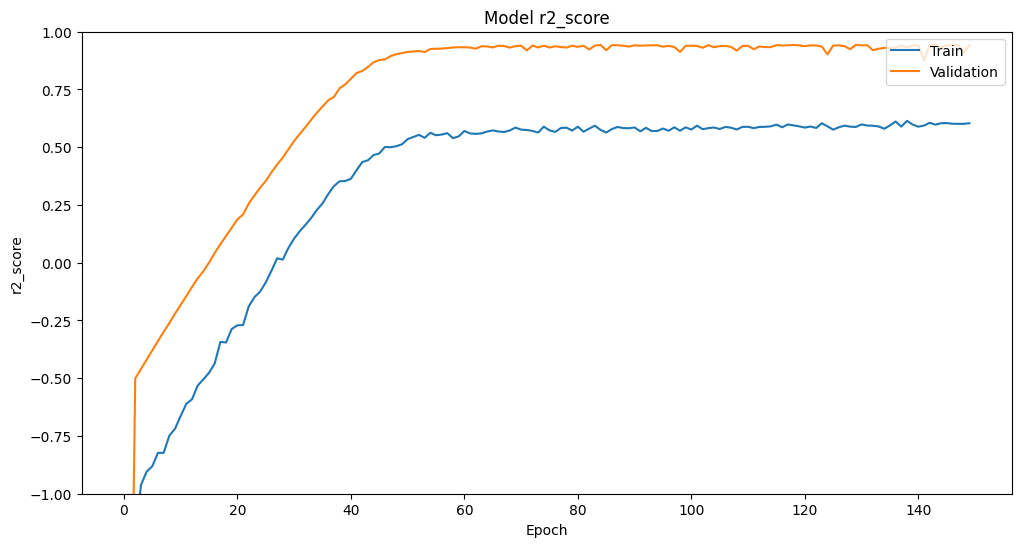

In [6]:
history = model.fit(X_Train, Y_train, validation_data=(x_val, Y_val), epochs=150, batch_size=128)
plot_history(history, 'r2_score', ylim=(-1, 1))

In [7]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, n_jobs=-1)
model.fit(X_Train, Y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_Train, Y_train)

LinearRegression()

In [9]:
import numpy as np
from sklearn.metrics import r2_score

predicted_val = model.predict(x_val)
predicted_val = predicted_val.reshape((1000, ))
predicted_val = predicted_val.astype(np.float64)

r2_score(Y_val, predicted_val)

ValueError: cannot reshape array of size 3000 into shape (1000,)

In [ ]:
import numpy as np
df_test = pd.read_csv('./data/task1/test.csv')
df_x_test = preprocess_data(df_test, True)

predicted = model.predict(df_x_test)
predicted = predicted.reshape((2000, ))
predicted = predicted.astype(np.float64)
predicted.shape

(2000,)

In [ ]:
with open('./data/task1/task1_solution_final_6001.npy', 'wb') as f:
    np.save(f, predicted)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your data
#df = pd.read_csv('training.csv')
df_x, df_y = preprocess_data(df_train)

# Assume 'flight_time' is your target variable
#X = df_x.drop('flight_time', axis=1)
#y = df_y['flight_time']

# Split your data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

# Create the regressor
regressor = LinearRegression()

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
predictions = regressor.predict(X_test)

predictions = predictions.reshape((2000, ))
predictions = predictions.astype(np.float64)


In [15]:
with open('./data/task1/task1_solution_final_6006.npy', 'wb') as f:
    np.save(f, predictions)